In [1]:
import os
import sys

diretorio_atual = os.getcwd()
print(f"Logado no diretório: {diretorio_atual}")
sys.path.append('/home/jovyan/work')

Logado no diretório: /home/jovyan/work


In [2]:
%load_ext autoreload
%autoreload 2
import utils.EDA_pandas as eda

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



# -------------------------------#
# Definindo os parâmetros globais
# -- Pandas

pd.set_option('display.max_columns', None)

# -- Matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams.update({
    'font.size': 12,                
    'axes.labelsize': 12,           
    'axes.titlesize': 12,           
    'xtick.labelsize': 10,          
    'ytick.labelsize': 10,          
    'legend.fontsize': 10,    
    'figure.titlesize': 10,         
    # 'axes.spines.right': False,     
    # 'axes.spines.top': False
    'savefig.dpi': 300,    
    'savefig.format': 'png',  
    'savefig.bbox': 'tight',      
    'savefig.pad_inches': 0.1       
})

experimento = 0

In [3]:
df_train_original = pd.read_csv('./data/bank-additional/bank-additional-full.csv', sep=';')
df_teste_original = pd.read_csv('./data/bank-additional/bank-additional.csv', sep=';') 


In [4]:
target = 'target'

# Renomeando a coluna 'y' para 'target'
df_train_original.rename(columns={'y': target}, inplace=True)
df_teste_original.rename(columns={'y': target}, inplace=True)

# Mapeando a variável target para 0 e 1
target_map = {'no': 0, 'yes': 1}
df_train_original[target] = df_train_original[target].map(target_map)
df_teste_original[target] = df_teste_original[target].map(target_map)

X_train = df_train_original.drop(columns=target)
y_train = df_train_original[target]

X_test = df_teste_original.drop(columns=target)
y_test = df_teste_original[target]



In [5]:
X_train.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0


In [6]:
X_test.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1
1,39,services,single,high.school,no,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0


In [7]:
transform_list = ['age', 'duration']
for col in transform_list:
    X_train[f'{col}_log'] = np.log1p(X_train[col])
    X_test[f'{col}_log'] = np.log1p(X_test[col])
    X_train = X_train.drop(columns=[col])
    X_test = X_test.drop(columns=[col])

In [8]:
# Remove as colunas que apresentam alta correlação
X_train = X_train.drop(columns=['emp.var.rate', 'euribor3m', 'nr.employed'])
X_test = X_test.drop(columns=['emp.var.rate', 'euribor3m', 'nr.employed'])

# Remove as colunas que apresentam IV: `usefull`
X_train = X_train.drop(columns=['day_of_week', 'housing', 'loan', 'pdays'])
X_test = X_test.drop(columns=['day_of_week', 'housing', 'loan', 'pdays'])

In [9]:
# Númericas
numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
print(numerical_features)

['campaign', 'previous', 'cons.price.idx', 'cons.conf.idx', 'age_log', 'duration_log']


In [10]:
# Categóricas
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
print(categorical_features)

['job', 'marital', 'education', 'default', 'contact', 'month', 'poutcome']


In [11]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd

# Definindo as variáveis numéricas
variaveis_numericas = ['campaign', 'previous', 'cons.price.idx', 'cons.conf.idx', 'age_log', 'duration_log']
scaler = StandardScaler()

# Ajustar o scaler aos dados de treino e transformá-los
# Usei o fit_transform para deixar o X_train_numerico como um numpy array
X_train_numerico = scaler.fit_transform(X_train[variaveis_numericas])

# Salve o scaler ajustado em um arquivo
import joblib
joblib.dump(scaler, f'./model/Experimento_{experimento}_scaler.pkl')

X_test_numerico = scaler.transform(X_test[variaveis_numericas])
X_test_numerico

array([[-0.20490853, -0.34949428, -1.17938048, -1.23103399, -1.00738083,
         1.10944488],
       [ 0.51711837, -0.34949428,  0.72272247,  0.88644656,  0.02275609,
         0.73756062],
       [-0.56592197, -0.34949428,  1.53642864, -0.28032844, -1.71823598,
         0.27953151],
       ...,
       [-0.20490853,  1.67113606, -1.17938048, -1.23103399, -1.41873155,
        -1.08912564],
       [-0.56592197, -0.34949428, -0.2274652 ,  0.95126739,  1.59350194,
         1.19742685],
       [-0.56592197, -0.34949428, -0.649003  , -0.32354233, -0.51690574,
        -0.0027829 ]])

In [12]:
from sklearn.preprocessing import OneHotEncoder

variaveis_categoricas = ['job', 'marital', 'education', 'default', 'contact', 'month', 'poutcome']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_categorico = encoder.fit_transform(X_train[variaveis_categoricas])
X_test_categorico = encoder.transform(X_test[variaveis_categoricas])

# Salvar o encoder ajustado em um arquivo
joblib.dump(encoder, f'./model/Experimento_{experimento}_encoder.pkl')

X_test_categorico

array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [13]:
# Combinando as variáveis numéricas e categóricas transformadas
X_train_transformado = np.hstack((X_train_numerico, X_train_categorico))
X_test_transformado = np.hstack((X_test_numerico, X_test_categorico))

**Transforma em Data Frame:** Apenas para visualização

In [14]:
# Adicionando o sufixo '_standard' às variáveis numéricas padronizadas
variaveis_numericas_standard = [f"{col}_standard" for col in variaveis_numericas]

# Criando DataFrames separados para os dados transformados de treino e teste
X_train_numerico_df = pd.DataFrame(X_train_numerico, columns=variaveis_numericas_standard, index=X_train.index)
X_test_numerico_df = pd.DataFrame(X_test_numerico, columns=variaveis_numericas_standard, index=X_test.index)


# Adicionando o sufixo '_encoded' aos nomes das colunas categóricas
colunas_categoricas_encoded = encoder.get_feature_names_out(variaveis_categoricas)
colunas_categoricas_encoded = [f"{col}_encoded" for col in colunas_categoricas_encoded]

# Convertendo os arrays transformados de volta para DataFrame para visualização
X_train_categorico_df = pd.DataFrame(X_train_categorico, columns=colunas_categoricas_encoded, index=X_train.index)
X_test_categorico_df = pd.DataFrame(X_test_categorico, columns=colunas_categoricas_encoded, index=X_test.index)


df_treino_transformado = pd.concat([X_train_categorico_df, X_train_numerico_df], axis=1)
df_teste_transformado = pd.concat([X_test_categorico_df, X_test_numerico_df, ], axis=1)

df_treino_transformado.head(2)

,job_admin._encoded,job_blue-collar_encoded,job_entrepreneur_encoded,job_housemaid_encoded,job_management_encoded,job_retired_encoded,job_self-employed_encoded,job_services_encoded,job_student_encoded,job_technician_encoded,job_unemployed_encoded,job_unknown_encoded,marital_divorced_encoded,marital_married_encoded,marital_single_encoded,marital_unknown_encoded,education_basic.4y_encoded,education_basic.6y_encoded,education_basic.9y_encoded,education_high.school_encoded,education_illiterate_encoded,education_professional.course_encoded,education_university.degree_encoded,education_unknown_encoded,default_no_encoded,default_unknown_encoded,default_yes_encoded,contact_cellular_encoded,contact_telephone_encoded,month_apr_encoded,month_aug_encoded,month_dec_encoded,month_jul_encoded,month_jun_encoded,month_mar_encoded,month_may_encoded,month_nov_encoded,month_oct_encoded,month_sep_encoded,poutcome_failure_encoded,poutcome_nonexistent_encoded,poutcome_success_encoded,campaign_standard,previous_standard,cons.price.idx_standard,cons.conf.idx_standard,age_log_standard,duration_log_standard
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.565922,-0.349494,0.722722,0.886447,1.454127,0.431124
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.565922,-0.349494,0.722722,0.886447,1.524415,-0.177114


In [15]:
## Treinamento:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Combinando as variáveis numéricas e categóricas transformadas
X_train_transformado = np.hstack((X_train_numerico, X_train_categorico))
X_test_transformado = np.hstack((X_test_numerico, X_test_categorico))

# Modelo de Regressão Logística
modelo_lr = LogisticRegression()
modelo_lr.fit(X_train_transformado, y_train)
y_pred_lr = modelo_lr.predict(X_test_transformado)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy Regressão Logística: {accuracy_lr:.2f}")

# Modelo SVM
modelo_svm = SVC()
modelo_svm.fit(X_train_transformado, y_train)
y_pred_svm = modelo_svm.predict(X_test_transformado)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy SVM: {accuracy_svm:.2f}")

# Modelo Random Forest
modelo_rf = RandomForestClassifier()
modelo_rf.fit(X_train_transformado, y_train)
y_pred_rf = modelo_rf.predict(X_test_transformado)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy Random Forest: {accuracy_rf:.2f}")

# Modelo XGBoost
modelo_xgb = XGBClassifier()
modelo_xgb.fit(X_train_transformado, y_train)
y_pred_xgb = modelo_xgb.predict(X_test_transformado)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy XGBoost: {accuracy_xgb:.2f}")


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy Regressão Logística: 0.91
Accuracy SVM: 0.92
Accuracy Random Forest: 1.00
Accuracy XGBoost: 0.95


In [16]:
import joblib


# Salvando o modelo treinado
joblib.dump(modelo_lr,  f'./model/Experimento_{experimento}_modelo_lr.pkl')
joblib.dump(modelo_svm, f'./model/Experimento_{experimento}_modelo_svm.pkl')
joblib.dump(modelo_rf,  f'./model/Experimento_{experimento}_modelo_rf.pkl')
joblib.dump(modelo_xgb, f'./model/Experimento_{experimento}_modelo_xgb.pkl')

# Carregando o modelo treinado
# modelo_lr_carregado = joblib.load(f'./model/Experimento_{experimento}_modelo_lr.pkl')
# modelo_svm_carregado = joblib.load(f'./model/Experimento_{experimento}_modelo_svm.pkl')
# modelo_rf_carregado = joblib.load(f'./model/Experimento_{experimento}_modelo_rf.pkl')
# modelo_xgb_carregado = joblib.load(f'./model/Experimento_{experimento}_modelo_xgb.pkl')


['./model/Experimento_0_modelo_xgb.pkl']

----
KS Value: 69.78
ROC AUC: 0.9234676606208909
Modelo: Regressão Logística
----
KS Value: 99.97
ROC AUC: 1.0
Modelo: Random Forest
----
KS Value: 84.25
ROC AUC: 0.9758884292025235
Modelo: XGBoost


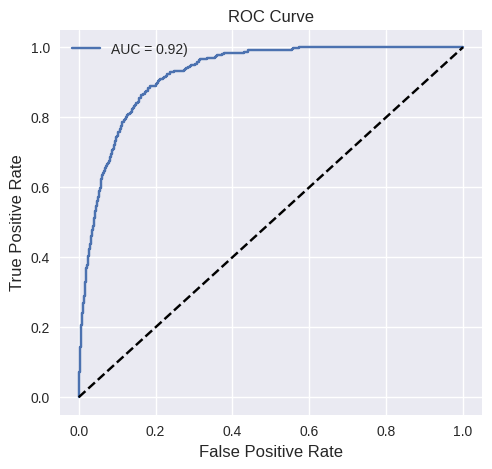

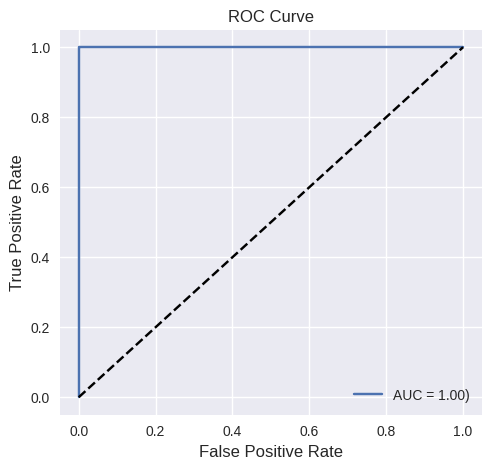

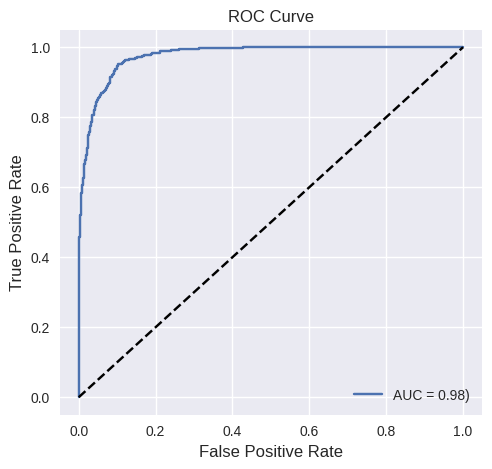

In [17]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


import utils.Evaluation_pandas as eval

# Combinando as variáveis numéricas e categóricas transformadas
X_train_transformado = np.hstack((X_train_numerico, X_train_categorico))
X_test_transformado = np.hstack((X_test_numerico, X_test_categorico))

# Função para plotar ROC AUC e KS
def plot_roc_ks(df, target_col, prob_col):
    
    # ROC AUC
    fpr, tpr, _ = roc_curve(df[target_col], df[prob_col])
    roc_auc = roc_auc_score(df[target_col], df[prob_col])
    
    kstable, ks_value = eval.calculate_ks(df, target_col, prob_col)
    print(f"KS Value: {ks_value}")
    print(f"ROC AUC: {roc_auc}")
    
    # Plotando ROC AUC
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')


# Modelos
models = {
    'Regressão Logística': modelo_lr,
    'Random Forest': modelo_rf,
    'XGBoost': modelo_xgb
}

for nome, modelo in models.items():
    y_prob = modelo.predict_proba(X_test_transformado)[:, 1]
    df_teste_predict = df_teste_original.copy()
    df_teste_predict['y_prob'] = y_prob
    plot_roc_ks(df = df_teste_predict, target_col = 'target', prob_col = 'y_prob')
    print(f"Modelo: {nome}")


Modelo: Regressão Logística


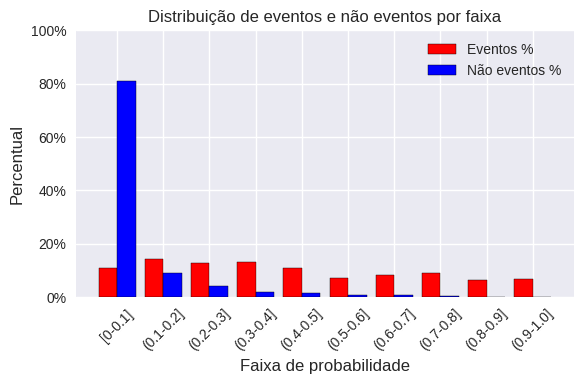

Modelo: Random Forest


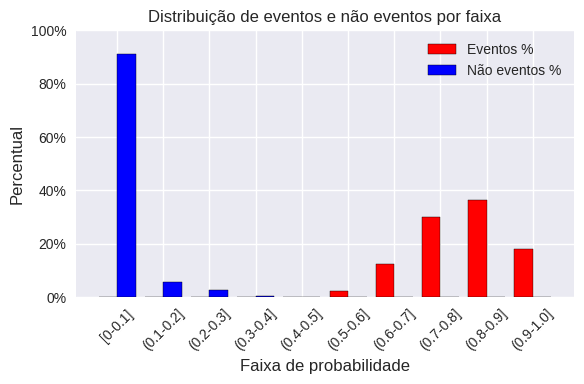

Modelo: XGBoost


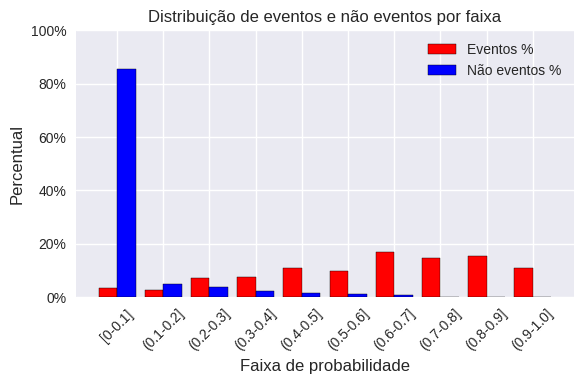

In [18]:
# Modelos
models = {
    'Regressão Logística': modelo_lr,
    'Random Forest': modelo_rf,
    'XGBoost': modelo_xgb
}
for name, model in models.items():
    print(f"Modelo: {name}")
    y_prob = model.predict_proba(X_test_transformado)[:, 1]
    df_teste_predict = df_teste_original.copy()
    df_teste_predict['y_prob'] = y_prob
    eval.plot_event_distribution(df = df_teste_predict, target_col = 'target', prob_col = 'y_prob')